# MSIYSP: Fastest Running Activities Analysis

*Generated by Claude Haiku 4.5 on Tuesday, November 11, 2025*

Find running activities representing the Pareto frontier of speed vs distance.

This notebook identifies running activities where there is no faster activity at a greater distance.

In [22]:
import sqlite3
import pandas as pd
from pathlib import Path
from datetime import datetime

# Connect to database
db_path = Path.cwd().parent / "msiysp_dev.db"
conn = sqlite3.connect(db_path)

print(f"Connected to: {db_path}")
print(f"Database exists: {db_path.exists()}")

Connected to: /Users/travis/Code/raulnor/msiysp/msiysp_dev.db
Database exists: True


In [23]:
# Query to find fastest running activities at each distance
# Returns activities where there is no faster activity at a greater distance
# Filters to running activities only, returns imperial units

query = """
SELECT 
    a1.id,
    a1.date,
    a1.type,
    a1.name,
    a1.distance_meters,
    a1.duration_seconds,
    ROUND(a1.distance_meters / 1609.34, 2) as distance_miles,
    PRINTF('%02d:%02d:%02d', 
        CAST(a1.duration_seconds / 3600 AS INTEGER),
        CAST((a1.duration_seconds % 3600) / 60 AS INTEGER),
        CAST(a1.duration_seconds % 60 AS INTEGER)
    ) as duration_hhmmss,
    PRINTF('%02d:%02d',
        CAST((a1.duration_seconds / (a1.distance_meters / 1609.34)) / 60 AS INTEGER),
        CAST(MOD(CAST(a1.duration_seconds / (a1.distance_meters / 1609.34) AS INTEGER), 60) AS INTEGER)
    ) as pace_mmss_per_mile,
    ROUND(a1.distance_meters / a1.duration_seconds, 3) as pace_m_per_sec,
    a1.strava_athlete_id,
    a1.strava_activity_id
FROM activities a1
WHERE a1.type = 'Run'
    AND NOT EXISTS (
        SELECT 1
        FROM activities a2
        WHERE a2.strava_athlete_id = a1.strava_athlete_id
            AND a2.type = 'Run'
            AND a2.distance_meters > a1.distance_meters
            AND (a2.distance_meters / a2.duration_seconds) > (a1.distance_meters / a1.duration_seconds)
    )
ORDER BY a1.distance_meters DESC, (a1.distance_meters / a1.duration_seconds) DESC;
"""

fastest_activities = pd.read_sql(query, conn)
print(f"\nFound {len(fastest_activities)} running activities on the Pareto frontier")
fastest_activities.head(10)


Found 12 running activities on the Pareto frontier


,id,date,type,name,distance_meters,duration_seconds,distance_miles,duration_hhmmss,pace_mmss_per_mile,pace_m_per_sec,strava_athlete_id,strava_activity_id
0,1761,2022-09-25T11:31:22Z,Run,Morning Run,55000.2,32674,34.18,09:04:34,15:56,1.683,31170827,7868053023
1,2789,2019-11-10T13:00:04Z,Run,Running,42843.9,12146,26.62,03:22:26,07:36,3.527,31170827,2858573845
2,2128,2021-11-14T12:30:05Z,Run,Harrisburg Marathon,42549.3,10907,26.44,03:01:47,06:52,3.901,31170827,6258801404
3,982,2024-11-10T12:31:47Z,Run,Harrisburg Marathon,42386.0,10515,26.34,02:55:15,06:39,4.000,31170827,12871320149
4,1196,2024-04-14T12:00:06Z,Run,Half Marathon,21353.6,5222,13.27,01:27:02,06:33,4.089,31170827,11184546132
5,1406,2023-09-10T12:00:11Z,Run,Harrisburg Half,21113.5,5075,13.12,01:24:35,06:26,4.160,31170827,9822260843
6,1045,2024-09-08T12:00:02Z,Run,Harrisburg Half Marathon 2024,20874.3,4859,12.97,01:20:59,06:14,4.296,31170827,12362050063
7,1538,2023-05-06T12:59:54Z,Run,PA DUI 10K,10082.7,2269,6.27,00:37:49,06:02,4.444,31170827,9021205429
8,866,2025-03-15T16:10:33Z,Run,Lucky Charm 4 Miler,6403.1,1426,3.98,00:23:46,05:58,4.490,31170827,13892661014
9,1309,2023-12-16T14:04:19Z,Run,Santa Shuffle 5k,4985.6,1099,3.10,00:18:19,05:54,4.536,31170827,10389426532


In [24]:
# Summary statistics
print("\n=== Fastest Running Activities Summary ===")
print(f"Total activities on frontier: {len(fastest_activities)}")
print(f"\nDistance range:")
print(f"  Min: {fastest_activities['distance_miles'].min():.2f} miles")
print(f"  Max: {fastest_activities['distance_miles'].max():.2f} miles")
print(f"\nPace range (mm:ss/mile):")
print(f"  Fastest: {fastest_activities['pace_mmss_per_mile'].min()}")
print(f"  Slowest: {fastest_activities['pace_mmss_per_mile'].max()}")


=== Fastest Running Activities Summary ===
Total activities on frontier: 12

Distance range:
  Min: 1.00 miles
  Max: 34.18 miles

Pace range (mm:ss/mile):
  Fastest: 05:17
  Slowest: 15:56


In [25]:
# Display all fastest activities in a readable format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

display_df = fastest_activities[[
    'date', 'name', 'distance_miles', 'duration_hhmmss', 'pace_mmss_per_mile'
]].copy()

display_df['date'] = pd.to_datetime(display_df['date']).dt.strftime('%Y-%m-%d')
display_df.columns = ['Date', 'Activity', 'Distance (mi)', 'Duration', 'Pace (mm:ss/mi)']

print("\n=== All Fastest Running Activities ===")
print(display_df.to_string(index=False))


=== All Fastest Running Activities ===
      Date                      Activity  Distance (mi) Duration Pace (mm:ss/mi)
2022-09-25                   Morning Run          34.18 09:04:34           15:56
2019-11-10                       Running          26.62 03:22:26           07:36
2021-11-14          Harrisburg Marathon           26.44 03:01:47           06:52
2024-11-10           Harrisburg Marathon          26.34 02:55:15           06:39
2024-04-14                 Half Marathon          13.27 01:27:02           06:33
2023-09-10               Harrisburg Half          13.12 01:24:35           06:26
2024-09-08 Harrisburg Half Marathon 2024          12.97 01:20:59           06:14
2023-05-06                    PA DUI 10K           6.27 00:37:49           06:02
2025-03-15           Lucky Charm 4 Miler           3.98 00:23:46           05:58
2023-12-16              Santa Shuffle 5k           3.10 00:18:19           05:54
2025-07-16                   Evening Run           1.02 00:05:23     

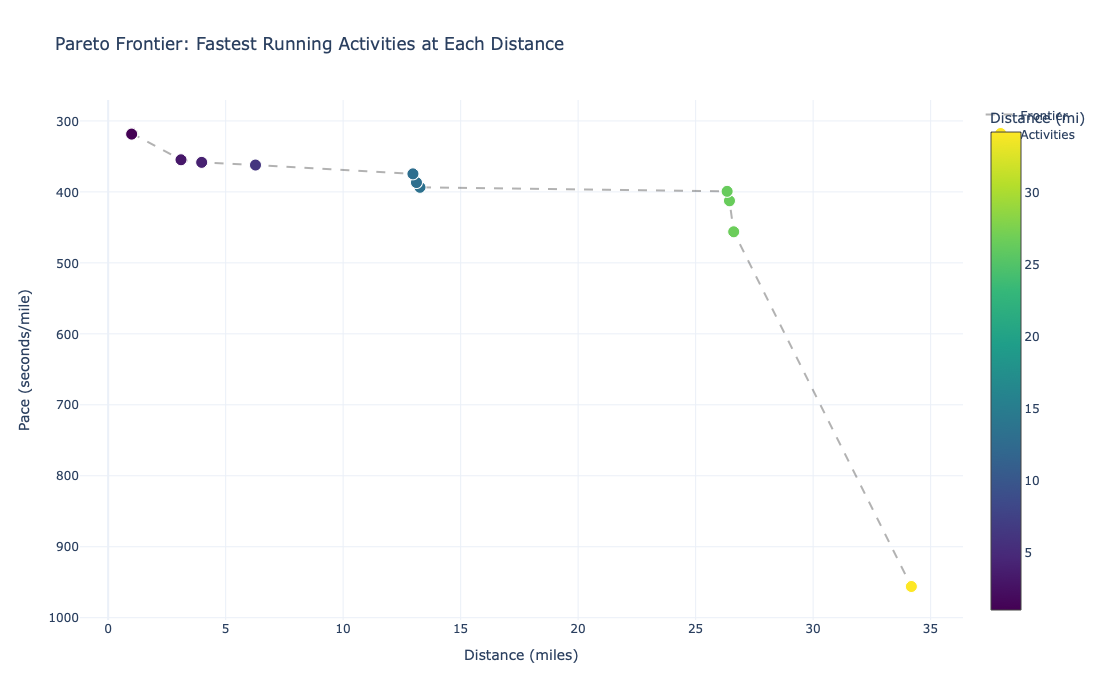

Chart shows running activities where no faster activity exists at a greater distance.


In [26]:
# Visualize the Pareto frontier
import plotly.graph_objects as go

# Calculate pace in seconds per mile for plotting (will convert back to mm:ss for display)
fastest_activities['pace_seconds_per_mile'] = fastest_activities['duration_seconds'] / (fastest_activities['distance_meters'] / 1609.34)

# Sort by distance for connecting line
frontier = fastest_activities.sort_values('distance_miles')

# Create scatter plot with frontier line
fig = go.Figure()

# Add frontier line
fig.add_trace(go.Scatter(
    x=frontier['distance_miles'],
    y=frontier['pace_seconds_per_mile'],
    mode='lines',
    name='Frontier',
    line=dict(color='rgba(0,0,0,0.3)', width=2, dash='dash')
))

# Add scatter points
fig.add_trace(go.Scatter(
    x=fastest_activities['distance_miles'],
    y=fastest_activities['pace_seconds_per_mile'],
    mode='markers',
    name='Activities',
    marker=dict(
        size=12,
        color=fastest_activities['distance_miles'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Distance (mi)'),
        line=dict(color='white', width=1)
    ),
    text=fastest_activities.apply(lambda row: f"<b>{row['name']}</b><br>Distance: {row['distance_miles']:.2f} mi<br>Duration: {row['duration_hhmmss']}<br>Pace: {row['pace_mmss_per_mile']}/mi", axis=1),
    hovertemplate='%{text}<extra></extra>'
))

fig.update_layout(
    title='Pareto Frontier: Fastest Running Activities at Each Distance',
    xaxis_title='Distance (miles)',
    yaxis_title='Pace (seconds/mile)',
    hovermode='closest',
    height=700,
    template='plotly_white'
)

# Invert y-axis so faster pace (lower values) is at top
fig.update_yaxes(autorange='reversed')

fig.show()
print("Chart shows running activities where no faster activity exists at a greater distance.")

In [27]:
# Optional: Find running activities that were "beaten" - faster activities at greater distances

beaten_query = """
SELECT 
    a1.date as beaten_date,
    a1.name as beaten_activity,
    ROUND(a1.distance_meters / 1609.34, 2) as beaten_distance_miles,
    PRINTF('%02d:%02d',
        CAST((a1.duration_seconds / (a1.distance_meters / 1609.34)) / 60 AS INTEGER),
        CAST(MOD(CAST(a1.duration_seconds / (a1.distance_meters / 1609.34) AS INTEGER), 60) AS INTEGER)
    ) as beaten_pace,
    a2.date as beating_date,
    a2.name as beating_activity,
    ROUND(a2.distance_meters / 1609.34, 2) as beating_distance_miles,
    PRINTF('%02d:%02d',
        CAST((a2.duration_seconds / (a2.distance_meters / 1609.34)) / 60 AS INTEGER),
        CAST(MOD(CAST(a2.duration_seconds / (a2.distance_meters / 1609.34) AS INTEGER), 60) AS INTEGER)
    ) as beating_pace
FROM activities a1
JOIN activities a2 ON a2.strava_athlete_id = a1.strava_athlete_id
WHERE a1.type = 'Run'
    AND a2.type = 'Run'
    AND a2.distance_meters > a1.distance_meters
    AND (a2.distance_meters / a2.duration_seconds) > (a1.distance_meters / a1.duration_seconds)
    AND a1.id NOT IN (
        SELECT a3.id FROM activities a3
        WHERE a3.type = 'Run'
        AND NOT EXISTS (
            SELECT 1 FROM activities a4
            WHERE a4.strava_athlete_id = a3.strava_athlete_id
                AND a4.type = 'Run'
                AND a4.distance_meters > a3.distance_meters
                AND (a4.distance_meters / a4.duration_seconds) > (a3.distance_meters / a3.duration_seconds)
        )
    )
ORDER BY a1.distance_meters DESC
LIMIT 20;
"""

beaten_activities = pd.read_sql(beaten_query, conn)
print(f"\nRecent running activities beaten by faster performances at greater distances:")
if len(beaten_activities) > 0:
    print(beaten_activities.head(10).to_string(index=False))
else:
    print("No beaten activities found - all current activities are on the frontier!")


Recent running activities beaten by faster performances at greater distances:
         beaten_date           beaten_activity  beaten_distance_miles beaten_pace         beating_date          beating_activity  beating_distance_miles beating_pace
2023-04-17T14:04:23Z               Morning Run                  26.41       06:54 2021-11-14T12:30:05Z      Harrisburg Marathon                    26.44        06:52
2022-11-13T12:40:26Z      Harrisburg Marathon                   26.14       06:46 2024-11-10T12:31:47Z       Harrisburg Marathon                   26.34        06:39
2019-10-12T17:09:35Z Wormleysburg / Harrisburg                  21.57       07:51 2019-11-10T13:00:04Z                   Running                   26.62        07:36
2019-10-12T17:09:35Z Wormleysburg / Harrisburg                  21.57       07:51 2021-11-14T12:30:05Z      Harrisburg Marathon                    26.44        06:52
2019-10-12T17:09:35Z Wormleysburg / Harrisburg                  21.57       07:51 2022-11-1

In [28]:
conn.close()
print("\nDatabase connection closed.")


Database connection closed.
